## Generate motion path figures.

Generate figures for motion paths.

In [1]:
from __future__ import print_function

import pygplates
import matplotlib.pyplot as plt
import numpy as np
import os.path
from scipy.signal import medfilt

import matplotlib as mpl
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "arial"
mpl.rcParams['text.usetex'] == True


#######################################################
# Define Input files
#######################################################

print(pygplates.__version__)

#model_dir = 'Global_Model_WD_Internal_Release_2019_v3'
model_dir = 'Global_1000-0_Model_2017'

if model_dir.startswith('Global_Model_WD_Internal_Release'):
    # Define the time snapshots at which to sample the motion paths
    min_time = 0.
    max_time = 410.
    time_step = 5.0

    rotation_base_filenames = [
        'Alps_Mesh_Rotations_2019_v2',
        'Andes_Flat_Slabs_Rotations_2019_v2',
        'Andes_Rotations_2019_v2',
        'Australia_Antarctica_Mesh_Rotations_2019_v2',
        'Australia_North_Zealandia_Rotations_2019_v2',
        'Eurasia_Arabia_Mesh_Rotations_2019_v2',
        'Global_250-0Ma_Rotations_2019_v2',
        'Global_410-250Ma_Rotations_2019_v2',
        'North_America_Flat_Slabs_Rotations_2019_v2',
        'North_America_Mesh_Rotations_2019_v2',
        'North_China_Mesh_Rotations_2019_v2',
        'Southeast_Asia_Rotations_2019_v2',
        'South_Atlantic_Rotations_2019_v2',
        'South_China_DeformingModel_xianzhi',
    ]
    
    # Motion path models to plot.
    model_infos = []

    # Motion path features.
    motion_path_feature_infos = {}
    
elif model_dir == 'Global_1000-0_Model_2017':
    # Define the time snapshots at which to sample the motion paths
    min_time = 0.
    max_time = 1000.
    time_step = 5.0
    
    rotation_base_filenames = ['1000_0_rotfile_Merdith_et_al']

    # Motion path models to plot.
    model_infos = [
        (None, 'red', 'Not Optimized'),
        #('svn1628_run10', 'blue', 'svn1628 run10 (TM=1;1, NR=1, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        #('svn1628_run12', 'green', 'svn1628 run12 (TM=1;0.5, NR=1, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        #('svn1628_run13', 'darkorange', 'svn1628 run13 (TM=1;1, NR=0.5, PV=1 | TM[-30,30], NR[0.08,0.2], PV[0,60])'),
        #('svn1628_run14', 'blue', 'run14 ref:OPT ang:30'),
        #('svn1628_run16', 'green', 'svn1628 run16 ref:NNR'),
        #('svn1628_run15', 'blue', 'svn1628 run15'),
        #('svn1628_run17', 'darkorange', 'svn1628 run17 trench cost: 10 x advancing samples'),
        ('svn1683_run21', 'purple', 'svn1683 run21 Ref:NNR NR=TM=1'),
        ('svn1683_run18', 'darkorange', 'svn1683 run18 Ref:opt NR=TM=1'),
        ('svn1683_run19', 'green', 'svn1683 run19 Ref:opt NR=1 TM=0.5'),
        ('svn1683_run20', 'blue', 'svn1683 run20 Ref:opt NR=0.5 TM=1'),
    ]

    # Motion path features and the range to plot lats/lons for all models.
    #
    # Note: The lat/lon range should include [-90,90] since latitudes cannot be wrapped around like longitudes.
    motion_path_feature_infos = {}
    
    # Create Africa motion path feature.
    africa_motion_path_feature = pygplates.Feature.create_reconstructable_feature(
            pygplates.FeatureType.gpml_unclassified_feature,
            # Specify a (lat/lon) seed point on the equator and in the middle of Africa.
            # Note: It's not exactly on equator but non-zero present day rotation puts it there.
            pygplates.PointOnSphere(0.0, 27.5),
            name='Africa',
            valid_time=(max_time, min_time),
            reconstruction_plate_id=701)
    motion_path_feature_infos['Africa'] = (africa_motion_path_feature, (-90, 270))
    
    # Create Laurentia motion path feature.
    laurentia_motion_path_feature = pygplates.Feature.create_reconstructable_feature(
            pygplates.FeatureType.gpml_unclassified_feature,
            # Specify a (lat/lon) seed point rouhgly in the middle of Laurentia.
            # Got this from "Global_1000-0_Model_2017/optimisation/motion_paths.gpml"...
            pygplates.PointOnSphere(46.1257, -96.5721),
            name='Laurentia',
            valid_time=(max_time, min_time),
            reconstruction_plate_id=101)
    motion_path_feature_infos['Laurentia'] = (laurentia_motion_path_feature, (-270, 90))
    
else:
    # Define the time snapshots at which to sample the motion paths
    min_time = 0.
    max_time = 410.
    time_step = 5.0
    
    rotation_base_filenames = []
    
    # Motion path models to plot.
    model_infos = []

    # Motion path features.
    motion_path_feature_infos = {}
    
input_dir = '../data/{0}'.format(model_dir)
output_dir = './{0}'.format(model_dir)

original_rotation_filenames = [os.path.join(input_dir, rotation_base_filename + '.rot')
        for rotation_base_filename in rotation_base_filenames]

# Typically the achor plate id should be 0
anchor_plate_id = 0

2.2.0.28


In [2]:
import pygplates


# A list of times to sample the motion path.
times = np.arange(min_time, max_time+1, time_step)

motion_path_models = {}

for motion_path_name, (motion_path_feature, motion_path_plot_lat_lon_range) in motion_path_feature_infos.items():
    motion_path_lats_list = []
    motion_path_lons_list = []
    
    # Each model for the current motion path gets a list of lats and a list of lons.
    motion_path_model = []
    motion_path_models[motion_path_name] = motion_path_model
    
    for model_info in model_infos:
        model_name, _, _ = model_info

        if model_name is None:
            # Un-optimised rotation model.
            rotation_model = pygplates.RotationModel(original_rotation_filenames)
        else:
            # Optimised rotation model.
            optimised_rotation_filenames = [
                    os.path.join(input_dir, 'optimisation', rotation_base_filename + '_{0}.rot'.format(model_name))
                        for rotation_base_filename in rotation_base_filenames]
            rotation_model = pygplates.RotationModel(optimised_rotation_filenames)
        
        # If the present day motion path rotation is non-zero then reverse rotate such that when it's
        # reconstructed to present day it will be at the seed position specified in the motion path feature.
        present_day_rotation = rotation_model.get_rotation(0.0, motion_path_feature.get_reconstruction_plate_id())
        if not present_day_rotation.represents_identity_rotation():
            motion_path_model_feature = motion_path_feature.clone()
            seed_point = motion_path_model_feature.get_geometry()
            seed_point = present_day_rotation.get_inverse() * seed_point
            motion_path_model_feature.set_geometry(seed_point)
        else:
            motion_path_model_feature = motion_path_feature

        # Current model for the current motion path gets a list of lats and a list of lons.
        motion_path_lats = []
        motion_path_lons = []
        motion_path_model.append((motion_path_lats, motion_path_lons))

        # Reconstruct the motion path.
        for time in times:
            # Reconstruct the motion path to the current time.
            reconstructed_motion_paths = []
            pygplates.reconstruct(motion_path_model_feature, rotation_model, reconstructed_motion_paths, time)

            # Motion path feature should just have one reconstructed feature.
            motion_path_lat, motion_path_lon = reconstructed_motion_paths[0].get_reconstructed_geometry().to_lat_lon()
            
            # Wrap longitude to the requested range if it's outside.
            if motion_path_lon < motion_path_plot_lat_lon_range[0]:
                motion_path_lon += 360
            elif motion_path_lon > motion_path_plot_lat_lon_range[1]:
                motion_path_lon -= 360

            motion_path_lats.append(motion_path_lat)
            motion_path_lons.append(motion_path_lon)


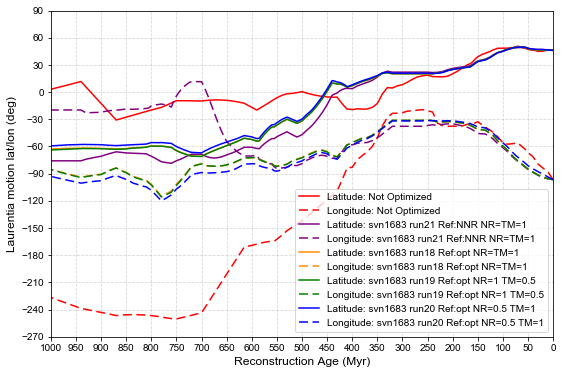

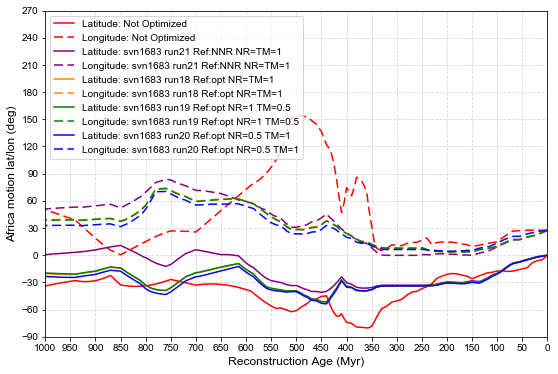

In [3]:
def plot_motion_paths(motion_path_name, motion_path_models, motion_path_plot_lat_lon_range, medfilt_kernel_sizes):
    
    for medfilt_kernel_size in medfilt_kernel_sizes:
        
        fig = plt.figure(figsize=(9,6))

        for model_index in range(len(model_infos)):
            motion_path_model = motion_path_models[model_index]
            
            motion_path_lats = motion_path_model[0]
            motion_path_lons = motion_path_model[1]
            
            _, color, label = model_infos[model_index]
            
            # Latitude.
            plt.plot(
                times,
                medfilt(motion_path_lats, medfilt_kernel_size),
                color,
                label='Latitude: {0}'.format(label))
            # Longitude.
            plt.plot(
                times,
                medfilt(motion_path_lons, medfilt_kernel_size),
                color,
                dashes=(6,3), # Same colour but with dashes.
                label='Longitude: {0}'.format(label))

        plt.xlim([min(times), max(times)])
        plt.ylim([motion_path_plot_lat_lon_range[0], motion_path_plot_lat_lon_range[1]])
        plt.xticks(np.arange(min_time, max_time+1, 50))
        plt.yticks(np.arange(motion_path_plot_lat_lon_range[0], motion_path_plot_lat_lon_range[1] + 1, 30))
        plt.ylabel('{0} motion lat/lon (deg)'.format(motion_path_name), fontsize=12)
        plt.xlabel('Reconstruction Age (Myr)', fontsize=12)
        plt.grid(linestyle='--',alpha=0.5)
        plt.gca().invert_xaxis() # Time should go from left to right.

        plt.legend(fontsize=10)

        plt.savefig(
            os.path.join(model_dir, 'motion_path_{0}_{1}My.pdf'.format(motion_path_name, medfilt_kernel_size)),
            format='pdf',
            dpi=600)

        plt.show()


#medfilt_kernel_sizes = [1, 5, 11]
medfilt_kernel_sizes = [1]

# Plot each motion path.
for motion_path_name, motion_path_model in motion_path_models.items():
    _, motion_path_plot_lat_lon_range = motion_path_feature_infos[motion_path_name]
    plot_motion_paths(motion_path_name, motion_path_model, motion_path_plot_lat_lon_range, medfilt_kernel_sizes)